# ECE 396 - HHL Algorithm
## Preparing the 3x3 invertible, non-hermitian A for HHL. 

In [46]:
import numpy as np



We need to define a 3 x 3 invertible but non-hermitian A in Qiskit. That is, the following two qualities must hold:
$$AA^{-1} = A^{-1}A = I_n$$
$$A \neq A^{\dag}$$
If we restric ourselves to only real values, the matrix we can choose must then follow the two qualities: invertible and $A\neq A^T$.

One such matrix is the following:

$$A = \Bigg(\begin{matrix}
    1 & 0 & 0 \\
    0 & 1 & 0 \\
    0 & 1 & 1 
\end{matrix}\Bigg)$$


In [47]:
A = np.matrix([[1, 0, 0], [0, 1, 0], [0, 1, 1]])
print(A)

[[1 0 0]
 [0 1 0]
 [0 1 1]]


Before I can use the HHL algorithm, we need to convert the non-hermitian matrix into a hermitian matrix form. We can complete this by performing the operation defined in the article. That is, define:
$$A' = \Bigg(\begin{matrix}
    0 & A \\
    A^{\dag} & 0 \end{matrix}\Bigg)$$
A' is now hermitian and can be used to solve  $A'\cdot y = \Bigg[\begin{matrix} b  \\ 0 \end{matrix}\Bigg]$; where $y = \Bigg[\begin{matrix} 0  \\ x \end{matrix}\Bigg]$

In [48]:
# define a 3x3 zero matrix for aid in construction
zero = np.matrix([[0, 0, 0], [0, 0, 0], [0, 0, 0]])

# construct A' to be a hermitian matrix
Ap = np.vstack((np.hstack((zero, A)), np.hstack((A.getH(), zero))))
print(Ap)

[[0 0 0 1 0 0]
 [0 0 0 0 1 0]
 [0 0 0 0 1 1]
 [1 0 0 0 0 0]
 [0 1 1 0 0 0]
 [0 0 1 0 0 0]]


HHL requires that the matrix $A$ is a $2^n x 2^n$ matrix. Our $A'$ is currently $6x6$, so we need to pad it to extend it to $8x8$. Our padding constraints need to maintain invertibility and hermitian-ness. To accomplish this, we pad the matrix to have 1's along the diagonal of the 2 added dimensions. For consistency, let's continue to call this matrix $A'$.

In [49]:
A_p = np.pad(Ap, ((0, 2), (0, 2)))

# pad 
A_p[-1][-1], A_p[-2][-2] = 1, 1
print(A_p)


[[0 0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0 0]
 [0 0 0 0 1 1 0 0]
 [1 0 0 0 0 0 0 0]
 [0 1 1 0 0 0 0 0]
 [0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 1]]


In [50]:
# initialize the b solution vector
b = np.array([1, 2, 3])

# pad the b array with 0's to be 8 by 1
b_p = np.resize(np.append(b, [0, 0, 0, 0, 0]), (8, 1))

In [51]:
A_p.shape

(8, 8)

Before implementing HHL ourselves, let's test it using Qiskit's pre-made model of HHL to be sure that our inputs work and to save to compare to in later testing stages.

In [52]:
from qiskit import Aer
from qiskit.algorithms.linear_solvers.hhl import HHL

backend = Aer.get_backend('aer_simulator')
hhl = HHL(quantum_instance=backend)

accurate_solution = hhl.solve(A_p, b_p)


/tmp/ipykernel_1014445/4218776720.py:5: DeprecationWarning: The HHL class is deprecated as of Qiskit Terra 0.22.0 and will be removed
        no sooner than 3 months after the release date.
        It is replaced by the tutorial at https://qiskit.org/textbook/ch-applications/hhl_tutorial.html"
        
  hhl = HHL(quantum_instance=backend)


## Implementing the HHL algorithm

### Defining parameters

In [62]:
t = 3000 # eep relatively large so that alpha in Eq (3) approximates as sync functions 
n_eig = 4 # number of qubits to estimate the eigenvalues of A, with precision up to n_eig bits

n = 3 # 2**n x 2**n A


In [54]:
import scipy
from qiskit.extensions import UnitaryGate

In [55]:
U_mat = scipy.linalg.expm(1j*A_p*t)

## Quantum Phase Estimation

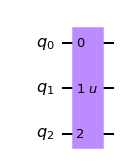

In [70]:
U = UnitaryGate(U_mat)
U.name = "$U$"
U_ctrl = U.control()
U_ctrl.label = "C-U"

circ = QuantumCircuit(3)
circ.append(U, range(3))
circ.draw('mpl')
# then calculate eigenvalues to see if they are nice...?

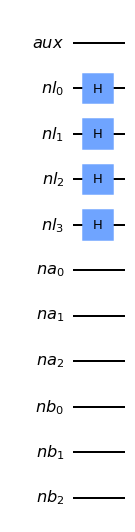

In [76]:
aux = QuantumRegister(1, 'aux') # for conditional eigenvalue inversion

n_l = QuantumRegister(n_eig, 'nl') # stores binary representation of the eigenvalues 
n_a = QuantumRegister(n,'na') # auxillary qubits (can be ignored...?)
n_b = QuantumRegister(n, 'nb') # contains the vector solution


circ = QuantumCircuit(aux, n_l, n_a, n_b)

circ.h(n_l)
circ.draw('mpl')

circ.draw('mpl')

First, perform a hadamard on all the memory qubits.

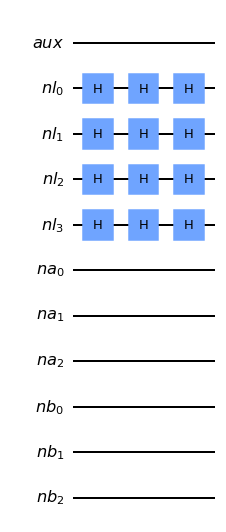